In [24]:
pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


In [25]:
import numpy as np
import pandas as pd
import time
import queue
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OneHotEncoder

In [26]:
# code to import dataset to python -- pasted from UCI ML repo 

from ucimlrepo import fetch_ucirepo 
   
default_of_credit_card_clients = fetch_ucirepo(id=350) 

default_cc = default_of_credit_card_clients.data.original

In [27]:
# Preprocessing: One Hot Encoding qualitative features to be used for Regression Tree implementation
def ohe_qual_feats(data):
    qual_feat = ['X2', 'X3', 'X4']
    for ql in qual_feat:
        oh_test = data[[ql]]
        ohe = OneHotEncoder(handle_unknown = 'ignore', sparse_output = False)
        one_hot_encoded = ohe.fit_transform(oh_test)
        one_hot_df = pd.DataFrame(one_hot_encoded, columns=ohe.get_feature_names_out([ql]))
        data = pd.concat([data, one_hot_df], axis = 1)
    data = data.drop(columns = ['X2', 'X3', 'X4'])
    return data

default_cc = ohe_qual_feats(default_cc)

In [28]:
# Creating X and y tables from original table that is then split into a training and testing set

X = default_cc.loc[:, default_cc.columns != 'Y'] 
y = default_cc.loc[:, 'Y'].to_frame(name = 'target')
   
default_of_credit_card_clients.data.original
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 45)

In [29]:
# Creating test_df which is the training data combined (so both the features and the target variable in one table)
# This is to have the DTs to be created based on the true values (target) 

test_df = X_train
test_df['target'] = y_train
test_df = test_df.drop('ID', axis = 1)


In [30]:
# for different points in a continuous feature, I wanted to find the boundary that minimizes the residuals
# this method gathers 9 points (percentiles from the data)
# I chose to do this over gradient descent simply because it is lest costly and would bring minimal change to the optimal boundary 

def minimize_stats(data, feat, target):
    quant_df = data[[feat]] 
    qs = np.array(quant_df.quantile([0.1, 0.25, 0.3, 0.4, 0.5, 0.6, 0.75, 0.8, 0.9])[feat])
    return qs


In [31]:
# need this particular formula to convert leaf outputs to predicted probabilities

def lodds_to_prob(l_odds):
    pred_prob =  np.exp(l_odds) / (1 + np.exp(l_odds))
    return pred_prob



In [32]:
# gets the residual reduction from a particular split of a feature
# weights False Negatives to be 4 times "more" than False Positives
# encourages residual trees to predict true positives correctly 

def get_rss(data, feat, target, bounds):
    rss_arr = np.empty(len(bounds))
    grad_arr = np.empty(len(bounds))
    
    for i, b in enumerate(bounds):
        dat_l = data[data[feat] > b]
        dat_u = data[data[feat] <= b]

        mean_l = np.mean(dat_l[target])
        mean_u = np.mean(dat_u[target])

        rss_l = 0
        rss_u = 0
        
        true_val_u = dat_u['target'].to_numpy()
        true_val_l = dat_l['target'].to_numpy()

        target_u = dat_u[target].to_numpy()
        target_l = dat_l[target].to_numpy()
        
        for j, u in enumerate(true_val_u):
            if u == 1:
                rss_u += 4*((target_u[j] - mean_u)**2)
            else:    
                rss_u += ((target_u[j] - mean_u)**2)
                
        for k, l in enumerate(true_val_l):
            if l == 1:
                rss_l += 4*((target_l[k] - mean_l)**2)
            else: 
                rss_l += ((target_l[k] - mean_l)**2)
        
        
        
        grad_l  = np.sum(-2*(dat_l[target]  - mean_l)) 
        grad_u = np.sum(-2*(dat_u[target] - mean_u))
        
        rss_arr[i] = rss_l + rss_u
        grad_arr[i] = grad_l + grad_u

    rss_min = np.min(rss_arr)
    min_ind = np.argmin(rss_arr)
    
    # returns minimum rss, the optimal split, gradient, the feature name, and the orginal dataframe
    return rss_min, bounds[min_ind], grad_arr[min_ind], feat, data

get_rss(test_df, 'X6', 'target', [0,1])

(np.float64(11409.97122969299),
 0,
 np.float64(-4.760636329592671e-13),
 'X6',
            X1  X5  X6  X7  X8  X9  X10  X11    X12    X13  ...  X3_2  X3_3  \
 25295   60000  24   0   0   0   0    0    0  50840  49592  ...   1.0   0.0   
 23909   80000  26  -1   3   2  -1    2    2    495    330  ...   1.0   0.0   
 25048  100000  54   0   0   0   0    5    4  37082  46041  ...   0.0   1.0   
 17022   80000  23   0   0   0   0    0    0   6805   8449  ...   1.0   0.0   
 5917   200000  46  -1  -1  -1  -1   -2   -2   1207   5590  ...   0.0   1.0   
 ...       ...  ..  ..  ..  ..  ..  ...  ...    ...    ...  ...   ...   ...   
 12895   50000  25   0   0   0   0    0    0  50485  50397  ...   1.0   0.0   
 28192  170000  34  -2  -2  -1   0    0   -2   1088   1088  ...   0.0   0.0   
 6012   360000  47  -2  -2  -2  -2   -2   -2   1458     -4  ...   0.0   1.0   
 6558   180000  30  -1  -1  -1  -1   -1   -2   1730   6792  ...   0.0   1.0   
 23499  140000  33   1  -1  -1  -1   -1   -1    -23

In [33]:
# for each point/node in tree, find the feature that minimizes the residual sum of squares
# this will select the feature/split for each DT node
# inputs are the data at that particular node, and target represents the feature that the DT is trying to predict

def minimal_rss_quant(data, target):
    feats = ['X1', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14',
       'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X2_1',
       'X2_2', 'X3_0', 'X3_1', 'X3_2', 'X3_3', 'X3_4', 'X3_5', 'X3_6', 'X4_0',
       'X4_1', 'X4_2', 'X4_3', target]
    dater = []
    min_rss = np.inf
    min_stats = None
    
    for f in feats:
        if f != target:
            bounds = minimize_stats(data, f, target)
            stats = get_rss(data, f, target, bounds)
            rss = stats[0]

            if rss < min_rss:
                min_rss = rss
                min_stats = stats
    return min_stats



In [34]:
# Created DTNode to represent each node of the DTs created, 
# DecisionTreeRegressor class helps traverse the tree, create the tree, and 
# identify which nodes are considered leaves (will be useful later) 

class DTNode: 

    def __init__(self):
        self.value = None
        self.left = None
        self.right = None


class DecisionTreeRegressor:

    def __init__(self, data, depth, target):
        self.depth = depth  
        self.data = data
        self.target = target

    def create_tree(self):
        self.dtree = build_tree(self.data, self.depth, self.target)
        return self.dtree

    def isLeaf(dtnode):
        return ((dtnode.right is None) and (dtnode.left is None))

In [35]:
# build_tree takes in the dataframe at this point (whatever split, the depth of the tree - as indicated when the DTRegressor class 
# is instantiated; uses recursion to continually split the new data split the most optimally, and continues until the indicated depth is reached

def build_tree(data, depth, target):
    if data.shape[0] > 0:
        root = DTNode()
        root.value = minimal_rss_quant(data, target)
    else: 
        return 0 
 
    if depth == 0:
        return root  
    else:
        children_data = create_children(data, root)
        
        root.left = DTNode()
        root.right = DTNode() 

        depth = depth - 1
        root.left = build_tree(children_data[0], depth, target)
        root.right = build_tree(children_data[1], depth, target)
    return root

# create_children is a helper function for build_tree in order to create new data frames upon splitting the data
# e.g. if the feature to split on is X6, and the value is 1 then create_children takes the data and splits it into the following:
# left node/dataframe : clients that have X6 <= 1 , right node/dataframe : clients that have X6 > 1

def create_children(data, node):
    feat_name = node.value[3]
    pivot_val = node.value[1]
    
    left_data = data[data[feat_name] <= pivot_val]
    right_data = data[data[feat_name] > pivot_val]

    return left_data, right_data

In [36]:
# get_new_val creates the new predictions for each leaf given the previous

def get_new_val(data, resid, guess_col):
    probs = lodds_to_prob(data[guess_col])
    new_pred = np.sum(data[resid]) / np.sum(probs * (1 - probs))
    return new_pred


In [37]:
# leaf_arr[1]



# for each decision tree,
# find what value the output will predict
# and then sum up those values F0 + v*sum blah blah (35:06)

# Testing...

# for each tree, store every node's split (less than + greater than/equal)
# Run test data through the tree to get leaves, (in testing... store leaf values to be able to assign them to test)
# Then repeat this with the next tree, with the predicted residuals/log(odds) from ^^^
# have 2nd tree data stored, and assign leaves and repeat until dones with all trees
# each observation shoudl now have some probability that it is 1 or 0, find probability threshold,, maybe use ROC or AUC to determine best threshold??
# then assign final predicted values 0, 1
# do model evaluations (confusion matrix, precision, recall, accuracy, F1 score, ROC curve

#get_F0(test_df)

In [38]:
# Get initial prediction 
def get_F0(data): 
    p_1 = data[data['target'] == 1].shape[0] / len(data['target'])
    odds = p_1 / (1 - p_1)
    log_odds = np.log(odds)
    return log_odds

def lodds_to_prob(l_odds):
    pred_prob =  np.exp(l_odds) / (1 + np.exp(l_odds))
    return pred_prob

class GBMInitializer:
    def __init__(self, data, depth):
        self.data = data
        self.depth = depth
        
    def initialize_data(self):
        lodds = get_F0(self.data)
        prob_0 = lodds_to_prob(lodds)
        self.data['F0'] = lodds
        self.data['pred. prob 0'] = prob_0
        self.data['residual 0'] = self.data['target'] - prob_0
        return 0

    def create_regression_tree(self, target):
        fake_tree = DecisionTreeRegressor(self.data, self.depth, target)
        doo = fake_tree.create_tree()
        return doo

    def create_model():
        return 0

In [39]:
def isLeaf(dtnode):
    return ((dtnode.right is None) and (dtnode.left is None))
    
def returnLeaves(root):
    leaf_arr = [] 
    def getLeaves(root_node): 
        if isLeaf(root_node):
            leaf_arr.append([root_node.value[4]])
        else:
            getLeaves(root_node.left)
            getLeaves(root_node.right)
    getLeaves(root)
    return leaf_arr

In [40]:
test_df

,X1,X5,X6,X7,X8,X9,X10,X11,X12,X13,...,X3_2,X3_3,X3_4,X3_5,X3_6,X4_0,X4_1,X4_2,X4_3,target
25295,60000,24,0,0,0,0,0,0,50840,49592,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
23909,80000,26,-1,3,2,-1,2,2,495,330,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
25048,100000,54,0,0,0,0,5,4,37082,46041,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
17022,80000,23,0,0,0,0,0,0,6805,8449,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
5917,200000,46,-1,-1,-1,-1,-2,-2,1207,5590,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12895,50000,25,0,0,0,0,0,0,50485,50397,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
28192,170000,34,-2,-2,-1,0,0,-2,1088,1088,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
6012,360000,47,-2,-2,-2,-2,-2,-2,1458,-4,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
6558,180000,30,-1,-1,-1,-1,-1,-2,1730,6792,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


In [41]:
def get_new_val(data, resid, probs):
    new_pred = np.sum(data[resid]) / np.sum(data[probs] * (1 - data[probs]))
    return new_pred


class GradientBoostingMachine:
    def __init__(self, data, num_learners, depth, dt_arr, learning_rate):
        self.data = data
        self.num_learners = num_learners
        self.depth = depth
        self.dt_arr = dt_arr
        self.learning_rate = learning_rate
        
    def train(self): 
        gbm = GBMInitializer(self.data, self.depth)
        gbm.initialize_data()
        dt_tree = gbm.create_regression_tree('residual 0')
        leaves = returnLeaves(dt_tree)

        self.dt_arr.append(dt_tree)
        pq_arr = []
        for i in range(1, self.num_learners + 1):
            new_leaves =[]
            pq = queue.Queue()
            for l in leaves:
                l = l.copy()
                new_pred = get_new_val(l[0], f'residual {i - 1}', f'pred. prob {i - 1}')
                #l.append(new_pred) # new line.. see if this works
                l[0].loc[:,f'F{i}'] = new_pred
                new_leaves.append(l[0])
                pq.put(new_pred)
            
            new_df = pd.concat(new_leaves, axis = 0)
            odds = new_df[f'F{i - 1}'] + self.learning_rate*new_df[f'F{i}']
            new_df[f'pred. prob {i}'] = lodds_to_prob(odds)
            new_df[f'residual {i}'] = new_df['target'] - new_df[f'pred. prob {i}']

            pq_arr.append(pq)
            ore = GBMInitializer(new_df, 2)
            dt_2 = ore.create_regression_tree(f'residual {i}')
            self.dt_arr.append(dt_2)
            leaves = returnLeaves(dt_2)
        return self.dt_arr, new_df, pq_arr

    
    def train_next_batches(self, resid_num):
        gbm = GBMInitializer(self.data, self.depth)
        dt_tree2 = gbm.create_regression_tree(f'residual {resid_num}')
        leaves = returnLeaves(dt_tree2)
        
        self.dt_arr.append(dt_tree2)
        pq_arr2 = []
        for i in range(resid_num + 1, resid_num + self.num_learners + 1):
            new_leaves =[]
            pq = queue.Queue()
            for l in leaves:
                l = l.copy()
                new_pred = get_new_val(l[0], f'residual {i - 1}', f'pred. prob {i - 1}')
                #l.append(new_pred) # new line.. see if this works
                l[0].loc[:,f'F{i}'] = new_pred
                new_leaves.append(l[0])
                pq.put(new_pred)
            
            new_df = pd.concat(new_leaves, axis = 0)
            odds = new_df[f'F{i - 1}'] + self.learning_rate*new_df[f'F{i}']
            new_df[f'pred. prob {i}'] = lodds_to_prob(odds)
            new_df[f'residual {i}'] = new_df['target'] - new_df[f'pred. prob {i}']

            pq_arr2.append(pq)
            ore = GBMInitializer(new_df, 2)
            dt_2 = ore.create_regression_tree(f'residual {i}')
            self.dt_arr.append(dt_2)
            leaves = returnLeaves(dt_2)
        return self.dt_arr, new_df, pq_arr2

In [42]:
# In order to run the testing data on the trees created through training,
# Made a traversal method to create the dataframes/leaves that result in the 
# Test data being run through the trees, then for each leaf, I assign the predicted
# Values that were found in training (the leaf_queue) 

def traverse_tree(data, dtree, num_learner, leaf_queue, leaf_list):
    
    root = dtree
    if isLeaf(root):
        # stop process of splitting     
        data.loc[:,f'F{num_learner}'] = leaf_queue.get()
        leaf_list.append(data)
        if leaf_queue.empty():
            return 0
    else:
        split_val = dtree.value[1]
        split_feat = dtree.value[3] 

        left_data = data[data[split_feat] <= split_val]
        right_data = data[data[split_feat] > split_val]

        traverse_tree(left_data, dtree.left, num_learner, leaf_queue, leaf_list)
        traverse_tree(right_data, dtree.right, num_learner, leaf_queue, leaf_list)



In [43]:
# The following code is used to create new "batches" (10 new learners/regression trees)
# In order to maintain JN's memory limit, each new csv file saves only the most recent prediction (log odds), probability, and residuals
# as these are the only "features" needed to build the next sequential learner 




# init_df = pd.read_csv('batch_9_train.csv') # CHANGE
# excluding_cols = []
# resid = 90 # CHANGE
# for i in range(resid): 
#     excluding_cols.append(f'F{i}')
#     excluding_cols.append(f'residual {i}')
#     excluding_cols.append(f'pred. prob {i}')
# train_df = init_df.loc[:, ~init_df.columns.isin(excluding_cols)]

# def train_test_batch(df, r_num, batch_num):
#     batch = GradientBoostingMachine(df, num_learners = 10, depth = 2, dt_arr = [], learning_rate = 0.05)
#     train_pred = batch.train_next_batches(resid_num = r_num)
#     dt_arr_len = len(train_pred[0])
#     dt_arr = train_pred[0][0:dt_arr_len - 1]
#     pq_arr = train_pred[2]
    
#     batch_df = train_pred[1]
#     batch_df.to_csv(f'batch_{batch_num}_train.csv', index = False)


#     X_test = pd.read_csv(f'batch_{batch_num - 1}_test.csv')
#     i = 0 
#     n_estimate = r_num
#     for d in dt_arr:
#         leaf_list = [] 
#         traverse_tree(X_test, d, n_estimate + 1, pq_arr[i], leaf_list)
#         X_test = pd.concat(leaf_list)
#         i += 1
#         n_estimate += 1
    
#     X_test.to_csv(f'batch_{batch_num}_test.csv', index = False)
# train_test_batch(train_df, resid, 10) # CHANGE

### GBM Implementation Performance Metrics

In [45]:
train_results = pd.read_csv('batch_10_train.csv')
train_results

,X1,X5,X6,X7,X8,X9,X10,X11,X12,X13,...,residual 97,F98,pred. prob 98,residual 98,F99,pred. prob 99,residual 99,F100,pred. prob 100,residual 100
0,80000,31,-2,-2,-2,-2,-2,-2,0,0,...,-0.376367,-0.853860,0.305534,-0.305534,0.025581,0.298892,-0.298892,-0.466154,0.500568,-0.500568
1,320000,32,-2,-2,-2,-2,-2,-2,-1,-1,...,0.623633,-0.853860,0.305534,0.694466,0.025581,0.298892,0.701108,-0.466154,0.500568,0.499432
2,100000,28,-2,-2,-2,-2,-1,-1,0,0,...,-0.376367,-0.853860,0.305534,-0.305534,0.025581,0.298892,-0.298892,-0.466154,0.500568,-0.500568
3,310000,43,-2,-2,-2,-2,-2,-2,0,0,...,-0.376367,-0.853860,0.305534,-0.305534,0.025581,0.298892,-0.298892,-0.466154,0.500568,-0.500568
4,290000,44,-2,-2,-2,-2,-2,-2,0,0,...,-0.376367,-0.853860,0.305534,-0.305534,0.025581,0.298892,-0.298892,-0.466154,0.500568,-0.500568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,150000,42,2,0,0,0,0,0,143947,147394,...,-0.236609,0.299051,0.476765,-0.476765,-0.910598,0.563043,-0.563043,-1.166168,0.275098,-0.275098
23996,150000,25,2,0,0,0,0,0,156252,121999,...,-0.236609,0.299051,0.476765,-0.476765,-0.910598,0.563043,-0.563043,-1.166168,0.275098,-0.275098
23997,130000,46,2,0,0,0,0,0,79705,59716,...,-0.236609,0.299051,0.476765,-0.476765,-0.910598,0.563043,-0.563043,-1.166168,0.275098,-0.275098
23998,220000,37,2,2,2,0,0,0,189976,189665,...,0.763391,0.299051,0.476765,0.523235,-0.910598,0.563043,0.436957,-1.166168,0.275098,0.724902


In [46]:
pred_arr = [] 
train_preds = train_results['pred. prob 100']
def try_threshold(p):
    for pred in train_preds:
        if pred <= p: 
            pred_arr.append(0)
        if pred > p:
            pred_arr.append(1)
    train_results['predicted target'] = pred_arr
    
    fpr_space = train_results[train_results['target'] == 0] 
    fps_pred = fpr_space[fpr_space['predicted target'] == 1]

    tpr_space = train_results[train_results['target'] == 1] 
    tps_pred = tpr_space[tpr_space['predicted target'] == 0]
    
    fpr = fps_pred.shape[0] / fpr_space.shape[0]
    tpr = tps_pred.shape[0] / tpr_space.shape[0]
    return fpr, tpr


unique_thresholds = train_results['pred. prob 100'].unique()
fpr_tpr_arr = []
for u in unique_thresholds:
    pred_arr = []
    train_preds = train_results['pred. prob 100']
    fpr, tpr = try_threshold(u)
    fpr_tpr_arr.append([u, fpr, tpr])



In [47]:
fpr_tpr_arr

[[np.float64(0.5005682443626555), 0.0, 1.0],
 [np.float64(0.3619798957544952), 0.10316693505099302, 0.6577281191806331],
 [np.float64(0.28213291519667), 0.23687600644122384, 0.3972067039106145],
 [np.float64(0.4215504005499201), 0.06011808910359635, 0.8175046554934823],
 [np.float64(0.2781720814655709), 0.33263553408480945, 0.3191806331471136],
 [np.float64(0.4167686208021049), 0.06333870101986044, 0.813780260707635],
 [np.float64(0.3744625938194448), 0.09382716049382717, 0.746927374301676],
 [np.float64(0.2931271694420759), 0.2170155662909286, 0.5312849162011173],
 [np.float64(0.4346877760393332), 0.05067096081588835, 0.9195530726256983],
 [np.float64(0.353936155359063), 0.21690821256038648, 0.5316573556797021],
 [np.float64(0.2750984523396937), 0.9994632313472893, 0.0005586592178770949],
 [np.float64(0.4130398773359012), 0.09377348362855609, 0.746927374301676]]

In [48]:
opt_threshold = fpr_tpr_arr[1][0]
opt_threshold

# chose the threshold that minimized the fpr and maximized the tpr for the training data,
# and used that as the threshold used to determine the class to assign each client in testing data

np.float64(0.3619798957544952)

In [50]:
test_results = pd.read_csv('batch_10_test.csv')

In [51]:
get_init = pd.read_csv('batch_1_train.csv')

predys = []

init_log_odds = get_init['F0'][0] #F0
for i in range(1, 101): 
    init_log_odds = init_log_odds + 0.1*test_results[f'F{i}']


for i in init_log_odds:
    if i >= 1000:
        predys.append(1)
    else:
        pred_prob = np.exp(i) / (np.exp(i) + 1)
        predys.append(pred_prob)

test_results['predicted probs'] = predys


pred_arr = [] 
for p in predys:
    if p <= opt_threshold: 
        pred_arr.append(0)
    if p > opt_threshold:
        pred_arr.append(1)

test_results['GBM predictions'] = pred_arr
test_results['Baseline predictions'] = 0

gb_accuracy = 1 - ((np.sum(np.abs(test_results['actual target'] - pred_arr))) / 6000)
baseline_accuracy = 1 - (np.sum(np.abs(test_results['actual target'] - 0)) / 6000)

gb_accuracy, baseline_accuracy

(np.float64(0.8236666666666667), np.float64(0.789))

In [52]:
# created these functions simply to refresh memory on model performance metrics, will use built in sklearn libs for comparison section
def get_TPR(data, target, pred):
    tp_space = data[data[target] == 1]     
    tp_df = tp_space[tp_space[pred] == 1]

    tp_num = tp_df.shape[0]
    tp_tot = tp_space.shape[0]
    tpr = tp_num / tp_tot
    
    return [tpr, tp_num, tp_tot ]

def get_FPR(data, target, pred):
    fp_space = data[data[target] == 0]     
    fp_df = fp_space[fp_space[pred] == 1]

    fp_num = fp_df.shape[0]
    fp_tot = fp_space.shape[0]
    fpr = fp_num / fp_tot
    return [fpr, fp_num, fp_tot]
    

baseline_fpr = get_FPR(test_results, 'actual target', 'Baseline predictions')[0]
baseline_tpr = get_TPR(test_results, 'actual target', 'Baseline predictions')[0]

gb_fpr = get_FPR(test_results, 'actual target', 'GBM predictions')[0]
gb_tpr = get_TPR(test_results, 'actual target', 'GBM predictions')[0]

gb_tp_num = get_TPR(test_results, 'actual target', 'GBM predictions')[1] 
gb_prec_tot = gb_tp_num + get_FPR(test_results, 'actual target', 'GBM predictions')[1]
baseline_precision =  0 # 0/0
gb_precision = gb_tp_num / gb_prec_tot

baseline_f1 = 0
gb_f1 = (2*gb_precision*gb_tpr) / (gb_precision + gb_tpr)

print(f'GBM accuracy: {gb_accuracy}, Baseline_accuracy: {baseline_accuracy}')
print(f'GBM TPR: {gb_tpr}, Baseline TPR: {baseline_tpr}')
print(f'GBM FPR: {gb_fpr}, Baseline FPR: {baseline_fpr}')
print(f'GBM TNR: {1 - gb_fpr}, Baseline TNR: {1 - baseline_fpr}')
print(f'GBM FNR: {1 - gb_tpr}, Baseline FNR: {1 - baseline_tpr}')
print(f'GBM Precision: {gb_precision}, Baseline Precision: {baseline_precision}')

print(f'GBM F1 Score: {gb_f1}, Baseline F1 Score: {baseline_f1}')

GBM accuracy: 0.8236666666666667, Baseline_accuracy: 0.789
GBM TPR: 0.33570300157977884, Baseline TPR: 0.0
GBM FPR: 0.04583861427967892, Baseline FPR: 0.0
GBM TNR: 0.954161385720321, Baseline TNR: 1.0
GBM FNR: 0.6642969984202212, Baseline FNR: 1.0
GBM Precision: 0.661993769470405, Baseline Precision: 0
GBM F1 Score: 0.44549266247379454, Baseline F1 Score: 0


### GBM Implementation vs. Scikit-learn's GBMClassifier

In [53]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [57]:
from sklearn.metrics import accuracy_score, classification_report

In [63]:
y_pred_imp = pred_arr
y_test_imp = test_results['actual target'].to_numpy()

In [61]:
from sklearn.ensemble import GradientBoostingClassifier

default_of_credit_card_clients = fetch_ucirepo(id=350)
X = default_of_credit_card_clients.data.features 
y = default_of_credit_card_clients.data.targets 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 45)

sklearn_gbm = GradientBoostingClassifier(n_estimators = 100, learning_rate = 0.05, max_depth = 2, random_state = 45)
sklearn_gbm.fit(X_train, y_train)

y_pred = sklearn_gbm.predict(X_test)

/srv/conda/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [66]:
# Evaluation: 
print("GBM Implementation Accuracy:", accuracy_score(y_test_imp, y_pred_imp))
print("Sklearn GBC Accuracy:", accuracy_score(y_test, y_pred))

print("\nGBM Implementation Classification Report:\n", classification_report(y_test_imp, y_pred_imp))
print("\nSklearn GBC Classification Report:\n", classification_report(y_test, y_pred))

GBM Implementation Accuracy: 0.8236666666666667
Sklearn GBC Accuracy: 0.8266666666666667

GBM Implementation Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.95      0.90      4734
           1       0.66      0.34      0.45      1266

    accuracy                           0.82      6000
   macro avg       0.75      0.64      0.67      6000
weighted avg       0.80      0.82      0.80      6000


Sklearn GBC Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.95      0.90      4734
           1       0.66      0.37      0.47      1266

    accuracy                           0.83      6000
   macro avg       0.75      0.66      0.68      6000
weighted avg       0.81      0.83      0.81      6000



In [ ]:
cm_imp = confusion_matrix(y_test_imp, y_pred_imp, labels = [0,1])

cm = confusion_matrix(y_test, y_pred, labels = [0,1])

Text(0.5, 1.0, 'Implemented GBM Confusion Matrix')

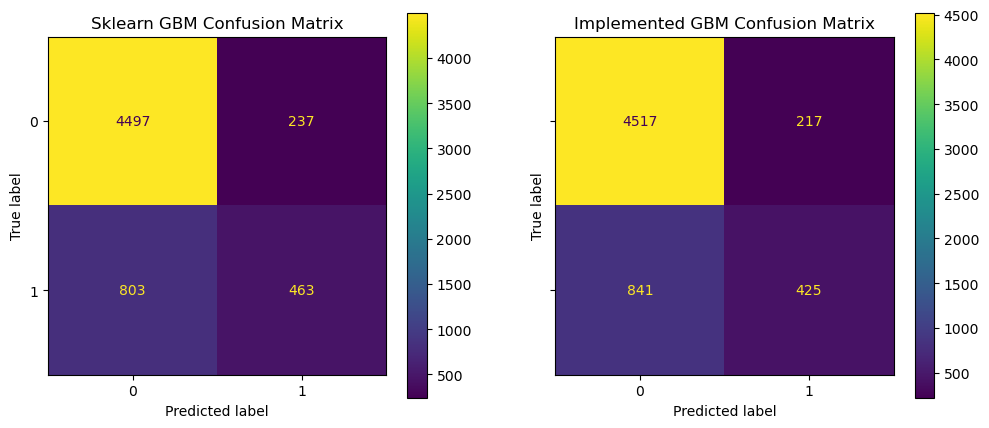

In [137]:
f, axes = plt.subplots(1,2, sharex = True, sharey = True, figsize = (12, 5))

plot_1 = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])
plot_1.plot(ax = axes[0])
axes[0].set_title('Sklearn GBM Confusion Matrix')

plot_2 = ConfusionMatrixDisplay(confusion_matrix = cm_imp, display_labels = [0, 1])
plot_2.plot(ax = axes[1])
axes[1].set_title('Implemented GBM Confusion Matrix')

In [106]:
# The implementation performs marginally better for predicting clients of class 0, 
# yet sklearn's GBClassifier performs better in predicting clients of class 1
# False Negatives are more important to minimizing, so sklearn's implementation
# still outperforms the implemented GBM slightly 

In [109]:
test_results

,ID,X1,X5,X6,X7,X8,X9,X10,X11,X12,...,F94,F95,F96,F97,F98,F99,F100,predicted probs,GBM predictions,Baseline predictions
0,5469,350000,33,-2,-2,-2,-2,-2,-2,-2,...,-0.853926,0.025503,-0.466076,-0.778388,-0.853860,0.025581,-0.466154,0.001459,0,0
1,22084,400000,27,-2,-2,-2,-2,-2,-2,0,...,-0.853926,0.025503,-0.466076,-0.778388,-0.853860,0.025581,-0.466154,0.001459,0,0
2,24578,310000,40,-2,-2,-2,-2,-2,-2,-150,...,-0.853926,0.025503,-0.466076,-0.778388,-0.853860,0.025581,-0.466154,0.001459,0,0
3,8553,50000,30,-2,-2,-2,-2,-2,-2,0,...,-0.853926,0.025503,-0.466076,-0.778388,-0.853860,0.025581,-0.466154,0.001459,0,0
4,15449,50000,27,-2,-2,-2,-2,-2,-2,0,...,-0.853926,0.025503,-0.466076,-0.778388,-0.853860,0.025581,-0.466154,0.001459,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,1989,140000,34,2,2,2,2,2,2,135949,...,0.298877,-0.293250,0.607247,1.559711,0.299051,-0.293104,0.607084,0.998792,1,0
5996,26565,200000,55,2,2,3,2,2,2,159017,...,0.298877,-0.293250,0.607247,1.559711,0.299051,-0.293104,0.607084,0.998792,1,0
5997,20246,80000,52,2,0,0,0,0,0,79822,...,0.298877,-0.910668,-1.165963,-0.107960,0.299051,-0.910598,-1.166168,0.005193,0,0
5998,27406,100000,44,2,2,0,0,0,0,40199,...,0.298877,-0.910668,-1.165963,-0.107960,0.299051,-0.910598,-1.166168,0.005193,0,0


In [ ]:
# see if we can implement roc curve, would be interesting to look at for model built from scratch

In [122]:
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score 
y_true = test_results['actual target']
y_score = test_results['predicted probs'] 

fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score, pos_label = 1)

/srv/conda/lib/python3.11/site-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


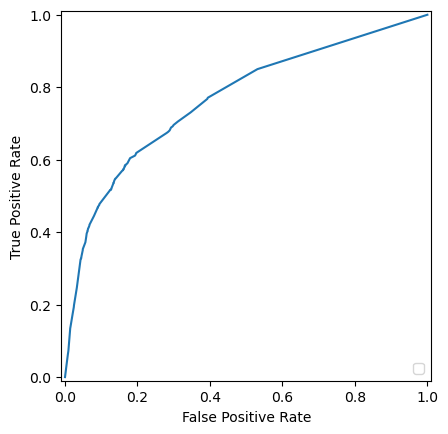

In [123]:
roc_display = RocCurveDisplay(fpr = fpr, tpr = tpr).plot()

In [124]:
roc_auc_score(y_true, y_score)

np.float64(0.7659681467999635)

In [126]:
y_baseline = np.zeros(6000)

In [128]:
roc_auc_score(y_true, y_baseline)

np.float64(0.5)